# Instalacja Bibliotek

In [ ]:
!pip install torchgeo
!pip install torch
!pip install pillow
!pip install matplotlib
!pip install numpy
!pip install tifffile


# Importy

In [ ]:
# importy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tifffile as tiff
import torchgeo


# Wyświetlenie przykładowego zdjęcia

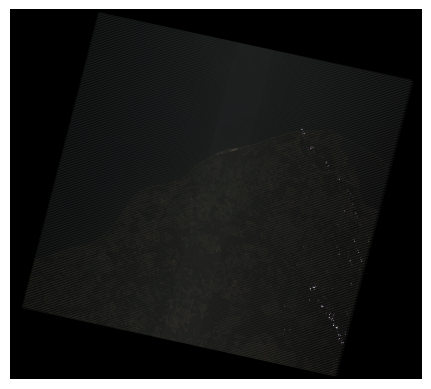

In [69]:
#tif_image = Image.open('Landsat/2019/LE07_L2SP_191022_20190415_20200827_02_T1_SR_B5.TIF')
# Ścieżki do plików z kanałami
band4_path = 'Landsat/2010/LE07_L2SP_191022_20100711_20200911_02_T1_SR_B3.TIF'  # Red
band3_path = 'Landsat/2010/LE07_L2SP_191022_20100711_20200911_02_T1_SR_B2.TIF'  # Green
band2_path = 'Landsat/2010/LE07_L2SP_191022_20100711_20200911_02_T1_SR_B1.TIF'  # Blue

# Otwórz kanały
band4 = tiff.imread(band4_path)
band3 = tiff.imread(band3_path)
band2 = tiff.imread(band2_path)

# Normalizacja kanałów (opcjonalnie, aby upewnić się, że wartości mieszczą się w zakresie 0-255)
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min) * 255).astype(np.uint8)

band4 = normalize(band4)
band3 = normalize(band3)
band2 = normalize(band2)

# Stwórz obraz RGB
rgb_image = np.dstack((band4, band3, band2))

# Wyświetl obraz
plt.imshow(rgb_image)
plt.axis('off')  # Ukryj osie
plt.show()

In [75]:
# segmentacja wcztanego zdjęcia landsat przy pimocy torchgeo

from torch.utils.data import DataLoader
from torchgeo.datasets import CDL, Landsat7, Landsat8, stack_samples
from torchgeo.samplers import RandomGeoSampler



In [107]:

landsat_dataset_2000 = Landsat7('Landsat/2000/')
landsat_dataset_2010 = Landsat7('Landsat/2010/')
landsat_dataset_2019 = Landsat7('Landsat/2019/')

dataset = landsat_dataset_2010 or landsat_dataset_2019 or landsat_dataset_2000


In [111]:

from torchvision.models.segmentation import deeplabv3_resnet50

import torchvision.transforms as transforms

# Load the pre-trained DeepLabv3 model
model = deeplabv3_resnet50(pretrained=True)

# Set the model to evaluation mode
model.eval()

# Define the image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Predict on landsat_dataset_2000
predictions = model(transform(landsat_dataset_2000[0]['image']).unsqueeze(0))['out']




/home/mikolaj/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mikolaj/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: 'int' object is not iterable

In [ ]:
from landsatxplore.api import API
from landsatxplore.earthexplorer import EarthExplorer
import os

# Dane logowania do USGS
username = 'Morpheus1024'
password = 'Niy$@Km!j6W2K9mzo5x#U@^#UzDFY#Bxb@sX%5PZwL2Pzc@GE33YhH4$cP'

# Inicjalizacja API
api = API(username, password)

# Wyszukiwanie scen Landsat 8
scenes = api.search(
    dataset='landsat_8_c1',
    latitude=52.2297,
    longitude=21.0122,
    start_date='2021-01-01',
    end_date='2021-12-31',
    max_cloud_cover=10
)

# Wypisanie znalezionych scen
for scene in scenes:
    print(scene['entity_id'], scene['acquisition_date'])

# Zamknięcie połączenia API
api.logout()

# Inicjalizacja EarthExplorer
ee = EarthExplorer(username, password)

# Pobieranie pierwszej znalezionej sceny
output_dir = 'landsat_data'
os.makedirs(output_dir, exist_ok=True)

if scenes:
    scene_id = scenes[0]['entity_id']
    ee.download(scene_id, output_dir=output_dir)

# Zamknięcie połączenia EarthExplorer
ee.logout()